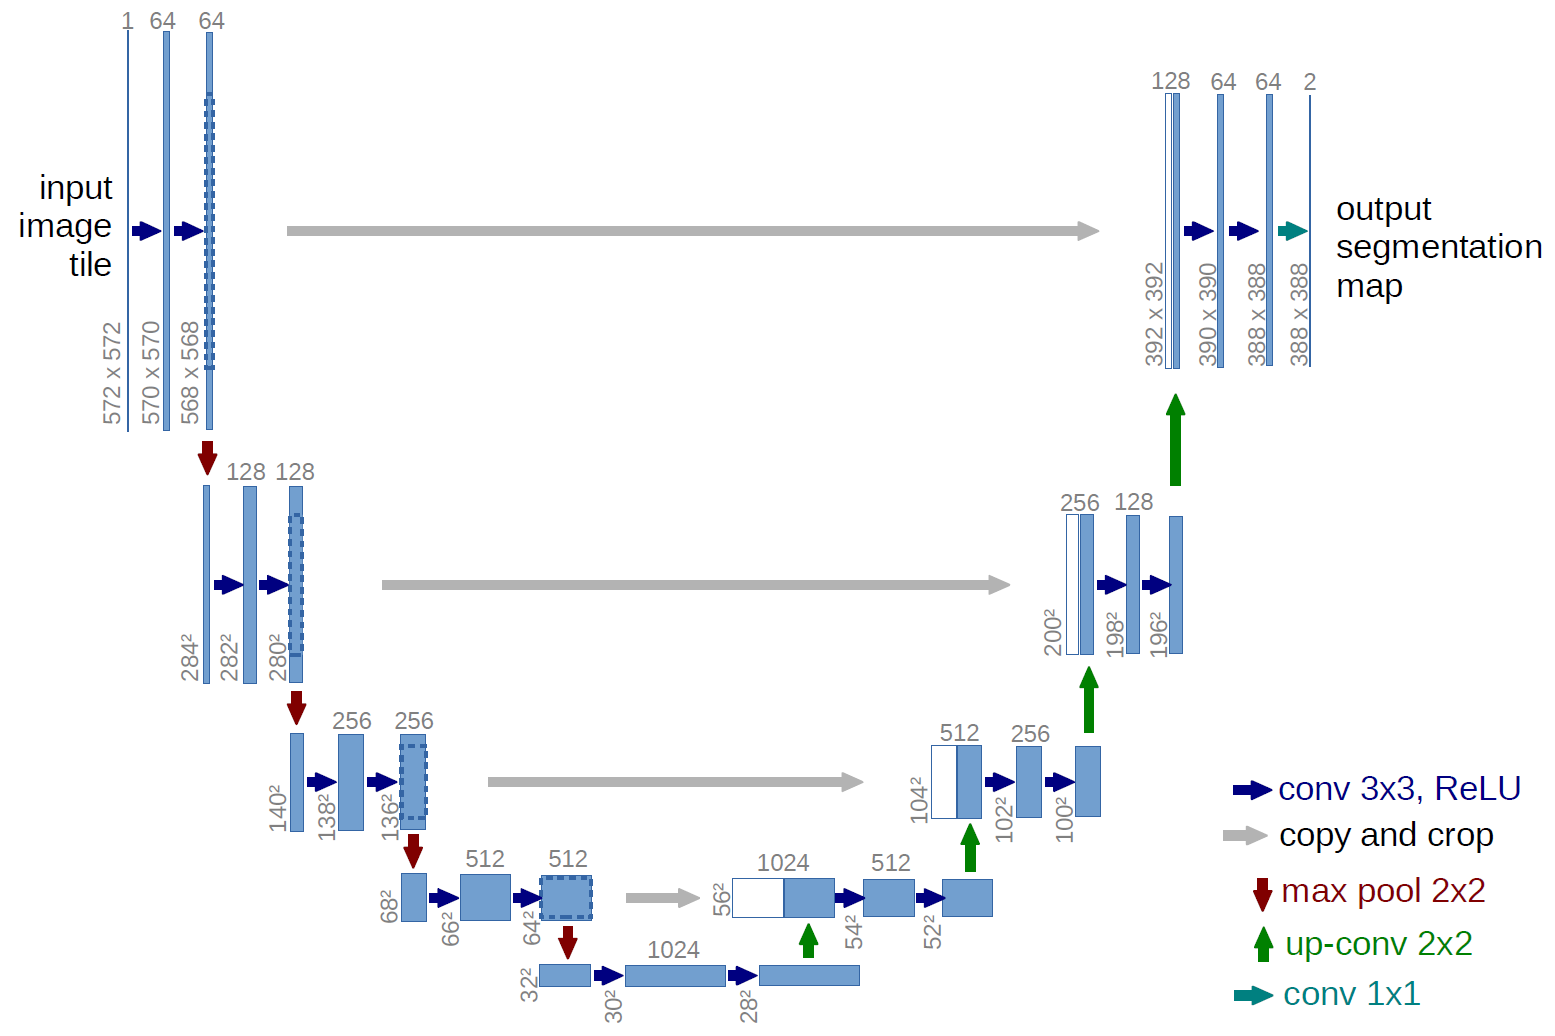

In [2]:
import torch
import torch.nn as nn

In [3]:
image = torch.rand(1, 1, 572, 572) #(batch,channel,W,H)


In [4]:
def double_convs(in_channels,out_channels,kernel_size=3):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size),
      nn.ReLU(inplace=True), # inplace=True This means that the output tensor is written to the same memory location as the input tensor -> more memory efficient
      nn.Conv2d(out_channels,out_channels,kernel_size),
      nn.ReLU(inplace=True),
  )

In [7]:
def crop_image(tensor , target_tensor):
  target_size = target_tensor.size()[2] # image.shape[-2]
  tensor_size = tensor.size()[2]
  delta = tensor_size - target_size # (572 - 262) = 10
  delta = delta //2  # answer is (5) cause we want to crop from left and right
  # delta : tensor_size - delta   --> 5 : 572 - 5 --> (5 : 567)
  return tensor [ : , : , delta : tensor_size - delta , delta : tensor_size - delta ]

In [8]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet,self).__init__()
    # Building Blocks
    self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2,stride=2)
    self.down_conv_1 = double_convs(1,64)
    self.down_conv_2 = double_convs(64,128)
    self.down_conv_3 = double_convs(128,256)
    self.down_conv_4 = double_convs(256,512)
    self.down_conv_5 = double_convs(512,1024)

    self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024,
                                         out_channels=512,
                                         kernel_size=2,
                                         stride=2)

    self.up_conv_1 = double_convs(1024,512)

    self.up_trans_2 = nn.ConvTranspose2d(in_channels=512,
                                         out_channels=256,
                                         kernel_size=2,
                                         stride=2)

    self.up_conv_2 = double_convs(512,256)

    self.up_trans_3 = nn.ConvTranspose2d(in_channels=256,
                                         out_channels=128,
                                         kernel_size=2,
                                         stride=2)

    self.up_conv_3 = double_convs(256,128)

    self.up_trans_4 = nn.ConvTranspose2d(in_channels=128,
                                         out_channels=64,
                                         kernel_size=2,
                                         stride=2)

    self.up_conv_4 = double_convs(128,64)

    self.out = nn.Conv2d(64,2,kernel_size=1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    # Encoder
    X1 = self.down_conv_1(x) # ---> x here is like the image we're passing into the model
    X2 = self.max_pool_2x2(X1) # maxpool then double convs
    X3 = self.down_conv_2(X2) # ---> double convs (64,128)
    X4 = self.max_pool_2x2(X3) # maxpool then double convs
    X5 = self.down_conv_3(X4)  # ---> double convs (128,256)
    X6 = self.max_pool_2x2(X5) # maxpool then double convs
    X7 = self.down_conv_4(X6) # ---> double convs (256,512)
    X8 = self.max_pool_2x2(X7) # maxpool then double convs
    X9 = self.down_conv_5(X8) # double convs (512,1024)

    print(f"The shape of the first Encoder part{X9.shape}") # check if it matches the paper

    # Decoder part

    X10 = self.up_trans_1(X9)
    # print(X10.shape)
    y = crop_image(X7,X10) # tensor swapping is bad here
    print(y.shape)
    X11 = self.up_conv_1(torch.concat((X10,y),1))
    print(X11.shape)

    X12 = self.up_trans_2(X11)
    y = crop_image(X5,X12) # tensor swapping is bad here
    X13 = self.up_conv_2(torch.concat((X12,y),1))
    print(X13.shape)

    X14 = self.up_trans_3(X13)
    y = crop_image(X3,X14) # tensor swapping is bad here
    X15 = self.up_conv_3(torch.concat((X14,y),1))
    print(X15.shape)

    X16 = self.up_trans_4(X15)
    y = crop_image(X1,X16) # tensor swapping is bad here
    X17 = self.up_conv_4(torch.concat((X16,y),1))
    print(X17.shape)

    X18 = self.out(X17)
    print(X18.shape)
    return X18



In [9]:
model_1 = UNet()
t = model_1(image)
print(t)

The shape of the first Encoder parttorch.Size([1, 1024, 28, 28])
torch.Size([1, 512, 56, 56])
torch.Size([1, 512, 52, 52])
torch.Size([1, 256, 100, 100])
torch.Size([1, 128, 196, 196])
torch.Size([1, 64, 388, 388])
torch.Size([1, 2, 388, 388])
tensor([[[[-0.0638, -0.0687, -0.0657,  ..., -0.0683, -0.0668, -0.0627],
          [-0.0627, -0.0635, -0.0664,  ..., -0.0664, -0.0637, -0.0605],
          [-0.0658, -0.0617, -0.0671,  ..., -0.0654, -0.0662, -0.0662],
          ...,
          [-0.0629, -0.0615, -0.0643,  ..., -0.0628, -0.0613, -0.0644],
          [-0.0632, -0.0655, -0.0623,  ..., -0.0631, -0.0677, -0.0688],
          [-0.0659, -0.0688, -0.0611,  ..., -0.0648, -0.0660, -0.0629]],

         [[ 0.0048,  0.0027, -0.0020,  ...,  0.0006, -0.0012, -0.0003],
          [ 0.0034,  0.0045,  0.0005,  ...,  0.0045, -0.0007, -0.0011],
          [ 0.0017,  0.0027,  0.0013,  ...,  0.0019,  0.0006, -0.0004],
          ...,
          [ 0.0016,  0.0028,  0.0045,  ...,  0.0009,  0.0018,  0.0069],
    

In [10]:
model_1

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_5): Sequential(
    (0): Conv2d(512, 1024, kernel_